# CNN Cancer Detection Mini Project

## EDA

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

(220025, 2)
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
dtype: int64


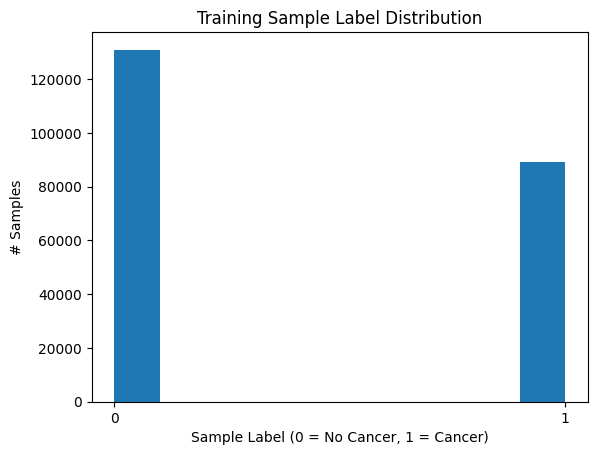

In [5]:
# Load the training labels and look at the label distribution

df_all = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print(df_all.shape)
print(df_all.describe())
print(df_all.head())

# Look at how many samples belong to each label
print(df_all.groupby('label').size())

plt.hist(df_all['label'])
plt.xlabel('Sample Label (0 = No Cancer, 1 = Cancer)')
plt.xticks([0, 1])
plt.ylabel('# Samples')
plt.title('Training Sample Label Distribution')
plt.show()

In [6]:
# Adding a column to the data frame for the image
# In order for the runtime to be reasonable, only running on 10,000 samples
# For a more robust model, I'd use all of the samples
df_sample = df_all.head(10000)

df_sample["img"] = df_sample["id"].apply(lambda x: mpimg.imread("/kaggle/input/histopathologic-cancer-detection/train/" + x + ".tif"))

<ipython-input-6-76160d31bd7d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["img"] = df_sample["id"].apply(lambda x: mpimg.imread("/kaggle/input/histopathologic-cancer-detection/train/" + x + ".tif"))


                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                                 img  
0  [[[246, 246, 244], [247, 247, 245], [249, 248,...  
1  [[[251, 247, 246], [253, 248, 245], [243, 238,...  
2  [[[255, 236, 255], [126, 88, 129], [122, 85, 1...  
3  [[[134, 75, 169], [164, 102, 188], [195, 128, ...  
4  [[[93, 23, 47], [147, 88, 120], [64, 19, 62], ...  
Label: 0


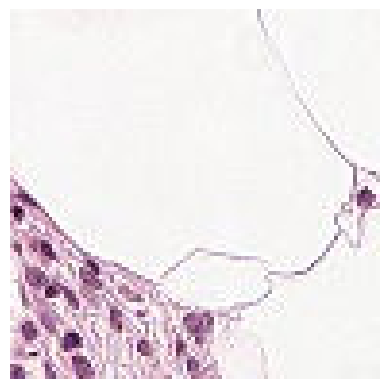

Label: 1


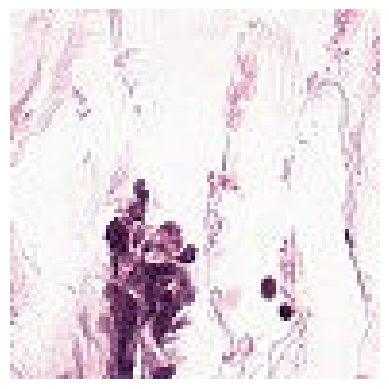

Label: 0


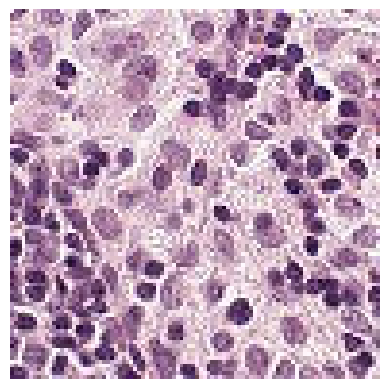

Label: 0


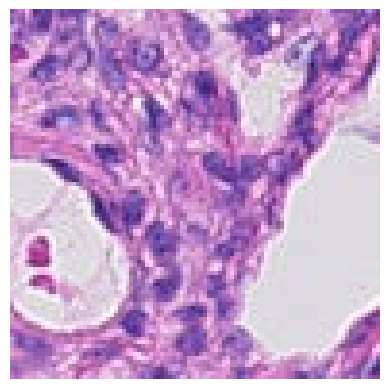

Label: 0


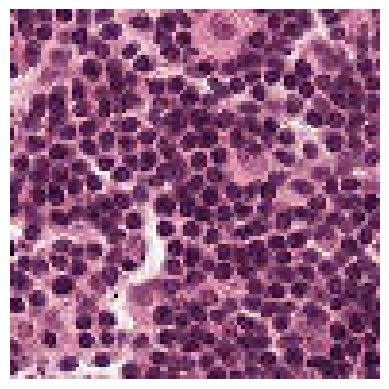

In [7]:
print(df_sample.head())

# Display the first 5 images along with the label
for i in range(5):
    img = df_sample.iloc[i]['img'] 
    label = df_sample.iloc[i]['label']
    
    plt.imshow(img)
    plt.axis('off')

    print(f'Label: {label}')
    plt.show()


## Model Building
First I'll split the dataset into training and test sets, then compile and fit the Sequential model

In [8]:
(df_train, df_test) = train_test_split(df_sample, random_state = 5, test_size = .25)
x_train = np.asarray(df_train["img"])
y_train = np.asarray(df_train["label"])
x_test = np.asarray(df_test["img"])
y_test = np.asarray(df_test["label"])

x_train = np.array([np.array(val) for val in x_train])
x_train = np.expand_dims(x_train, -1)
y_train = keras.utils.to_categorical(y_train, num_classes=2)

x_test = np.array([np.array(val) for val in x_test])
x_test = np.expand_dims(x_test, -1)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(96, 96, 3)),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(2, activation="softmax"),
    ]
)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 642ms/step - accuracy: 0.5365 - loss: 74.4313 - val_accuracy: 0.5960 - val_loss: 0.6343
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.6160 - loss: 0.6273 - val_accuracy: 0.6107 - val_loss: 0.6249
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - accuracy: 0.6222 - loss: 0.6127 - val_accuracy: 0.5413 - val_loss: 0.6325
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 645ms/step - accuracy: 0.5937 - loss: 0.5971 - val_accuracy: 0.5413 - val_loss: 0.6419
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 645ms/step - accuracy: 0.6236 - loss: 0.5845 - val_accuracy: 0.5453 - val_loss: 0.6447
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.6517 - loss: 0.5712 - val_accuracy: 0.5693 - val_loss: 0.6682
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 641ms/step - accuracy: 0.6981 - loss: 0.5230 - val_accuracy: 0.6920 - val_loss: 0.6499
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.7651 - loss: 0.4653 - val_acc

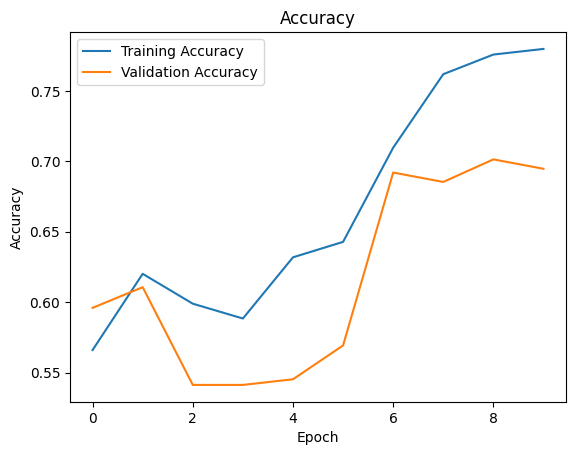

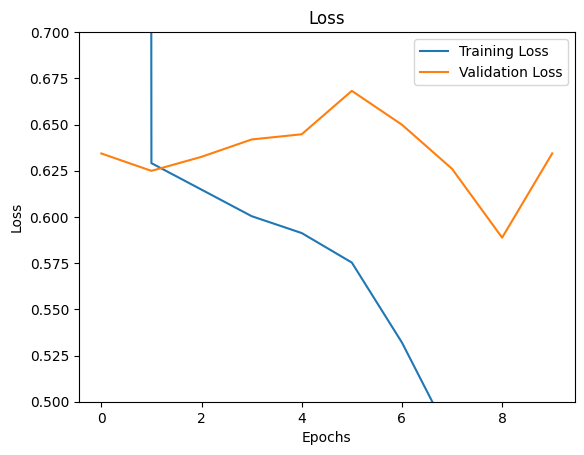

In [10]:
accuracy = epochs.history['accuracy']
val_accuracy = epochs.history['val_accuracy']
loss = epochs.history['loss']
val_loss = epochs.history['val_loss']
epochs_range = range(len(accuracy))

plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(.5, .7) # first epoch has an extremely high loss value, so limit the y axis to make the loss graph readable
plt.legend()
plt.title('Loss')

plt.show()

## Hyperparameter Tuning

Since the accuracy graph shows that the accuracy might still have been converging in later epochs, I'll try running the model again, but with more epochs and with early stopping.

In [16]:
model_es = keras.Sequential(
    [
        keras.Input(shape=(96, 96, 3)),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(2, activation="softmax"),
    ]
)
model_es.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

epoch_history_es = model_es.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=[early_stopping])

score = model_es.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - accuracy: 0.5367 - loss: 105.9250 - val_accuracy: 0.5987 - val_loss: 0.6321
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - accuracy: 0.6133 - loss: 0.6301 - val_accuracy: 0.6067 - val_loss: 0.6386
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 658ms/step - accuracy: 0.6243 - loss: 0.6130 - val_accuracy: 0.6093 - val_loss: 0.6321
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - accuracy: 0.6339 - loss: 0.6089 - val_accuracy: 0.6147 - val_loss: 0.6296
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 657ms/step - accuracy: 0.6383 - loss: 0.5973 - val_accuracy: 0.5400 - val_loss: 0.6404
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - accuracy: 0.5905 - loss: 0.5918 - val_accuracy: 0.5440 - val_loss: 0.6424
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 657ms/step - accuracy: 0.5867 - loss: 0.5949 - val_accuracy: 0.5347 - val_loss: 0.6546
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 659ms/step - accuracy: 0.5871 - loss: 0.5833 - val_ac

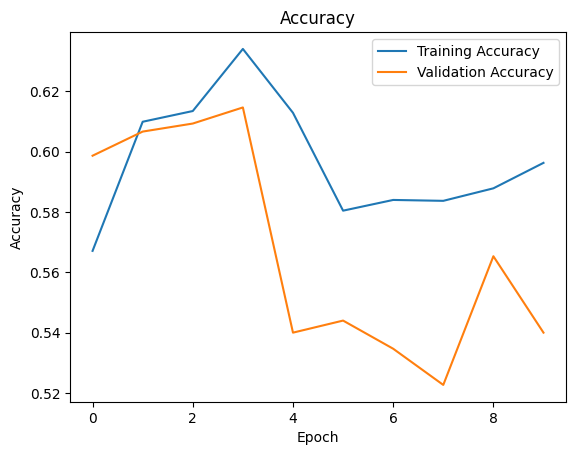

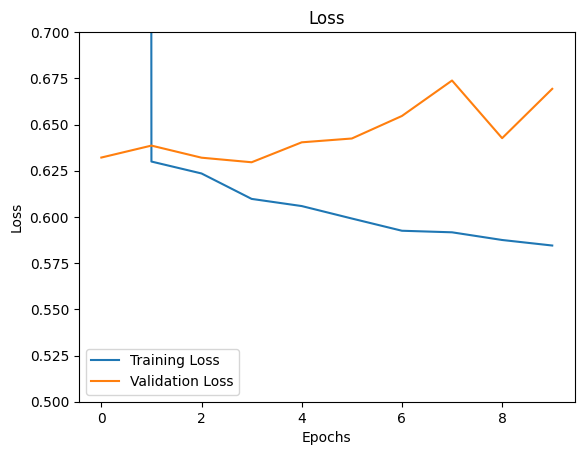

In [17]:
accuracy = epoch_history_es.history['accuracy']
val_accuracy = epoch_history_es.history['val_accuracy']
loss = epoch_history_es.history['loss']
val_loss = epoch_history_es.history['val_loss']
epochs_range = range(len(accuracy))

plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(.5, .7)
plt.legend()
plt.title('Loss')

plt.show()

In [18]:
model_es.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │          61,954 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244,040 (953.29 KB)

 Trainable params: 81,346 (317.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 162,694 (635.53 KB)

## Running the Kaggle Test Set
It looks like the first model produced better results, so I'll use that for my submission. Now I'll run the model against the test dataset and submit to the Kaggle competition.

In [19]:
filenames = os.listdir('//kaggle/input/histopathologic-cancer-detection/test/')
images = [mpimg.imread('//kaggle/input/histopathologic-cancer-detection/test/' + filename) for filename in filenames]

ids = [filename.replace('.tif', '') for filename in filenames]

df_submission = pd.DataFrame({'id': ids, 'img': images})

In [20]:
x_submission = np.asarray(df_submission["img"])

x_submission = np.array([np.array(val) for val in x_submission])
x_submission = np.expand_dims(x_submission, -1)

y_submission = model.predict(x_submission)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step


In [32]:
print(y_submission)

# Whichever label is larger is the label to use
y_labels = []
for y in y_submission:
    if y[0] > y[1]:
        y_labels.append(0)
    else:
        y_labels.append(1)

df_final = pd.DataFrame({'id': ids, 'label': y_labels})
print(df_final.head())

df_final.to_csv('submission.csv', index=False)

[[7.9822427e-01 2.0177574e-01]
 [9.9961323e-01 3.8686016e-04]
 [1.1532205e-01 8.8467789e-01]
 ...
 [6.4564584e-04 9.9935424e-01]
 [5.4166085e-01 4.5833918e-01]
 [5.3849953e-01 4.6150053e-01]]
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      1
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
